ModuleNotFoundError: No module named 'yfinance'

In [ ]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

#in practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Simulate Buying and Selling Stock Using ARMA(p,q)

In [60]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt

    #go through dates
    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data til just before current date
        curr_data = returns[:date]
        
        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=order).fit(maxiter=200)

                #get forecast
                pred = model.forecast()[0][0]

            except:
                pred = thresh - 1



        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
        ((type(order) == float and np.random.random() < order) 
         or (type(order) == tuple and pred > thresh)
         or (order == 'last' and curr_data.iloc[-1] > 0)):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)
                
    if verbose:
        print('Total Amount: $%s'%round(amt,2))
        
    #graph
    if plot:
    
        plt.figure(figsize=(10,4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
    
    return amt

# Read Data

In [131]:
tickerSymbol ='META'
data = yf.Ticker(tickerSymbol)

In [158]:
prices = data.history(start='2024-01-11', end='2024-04-11').Close
returns = prices.pct_change().dropna()

Text(0, 0.5, 'Prices')

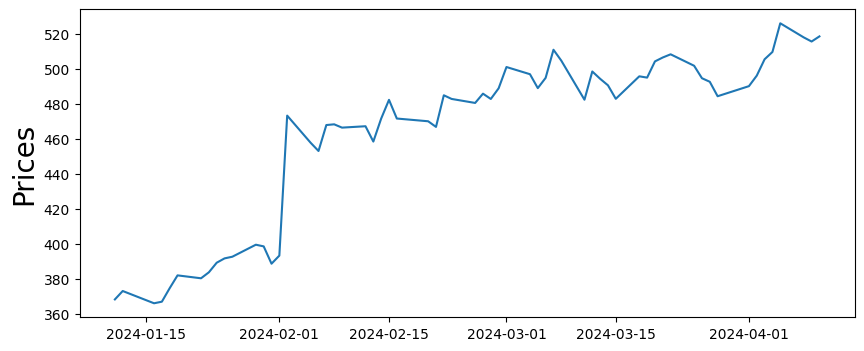

In [159]:
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.ylabel('Prices', fontsize=20)

Text(0, 0.5, 'Return')

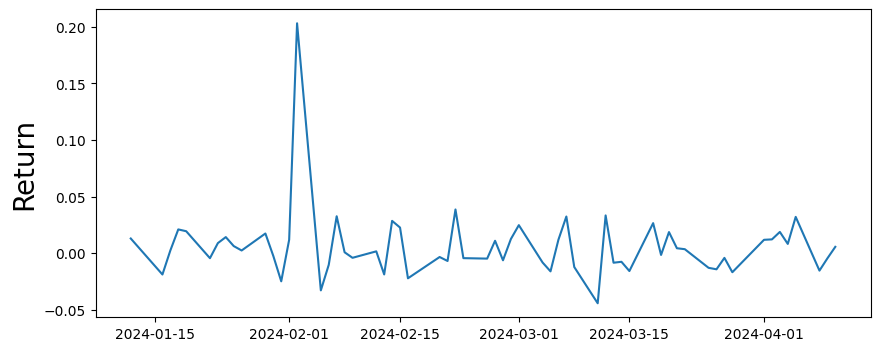

In [160]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Return', fontsize=20)

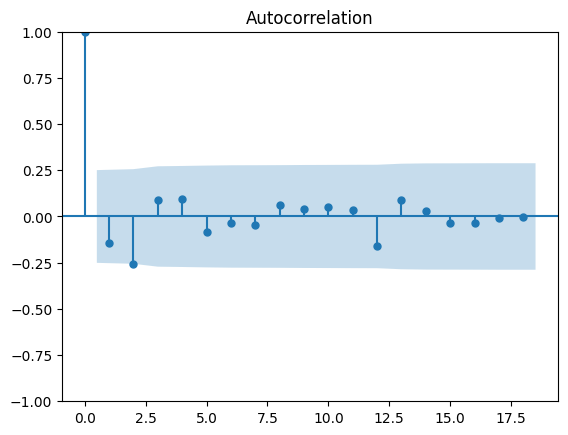

In [161]:
plot_acf(returns)
plt.show()

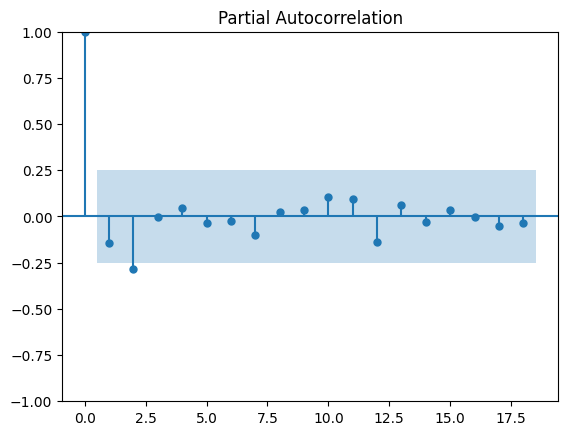

In [162]:
plot_pacf(returns)
plt.show()

# Baseline Model : Random Buying 

100%|██████████| 47/47 [00:00<00:00, 11747.35it/s]


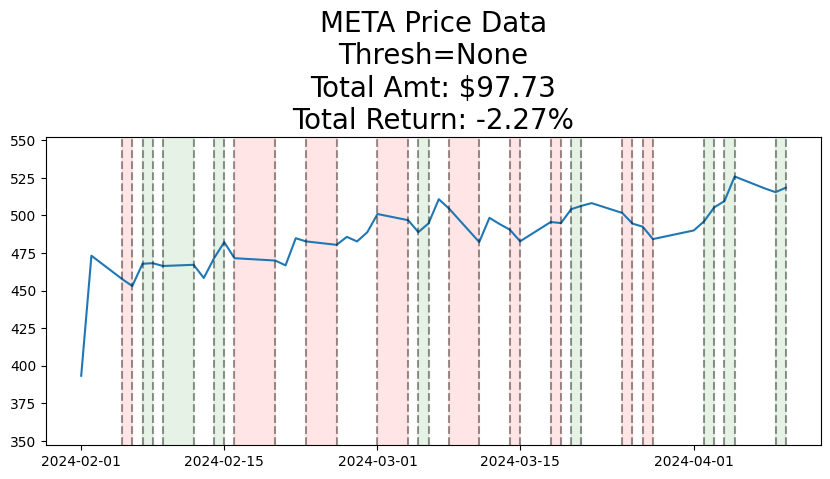

np.float64(97.72950983361636)

In [163]:
run_simulation(returns, prices, 100, 0.5, None, verbose=False)

In [164]:
final_amts = [run_simulation(returns, prices, 100, 0.5, None, verbose=False, plot=False) for _ in range(1000)]

100%|██████████| 47/47 [00:00<00:00, 15689.00it/s]


Text(0.5, 1.0, 'Avg: $103.06\nSD: $6.2')

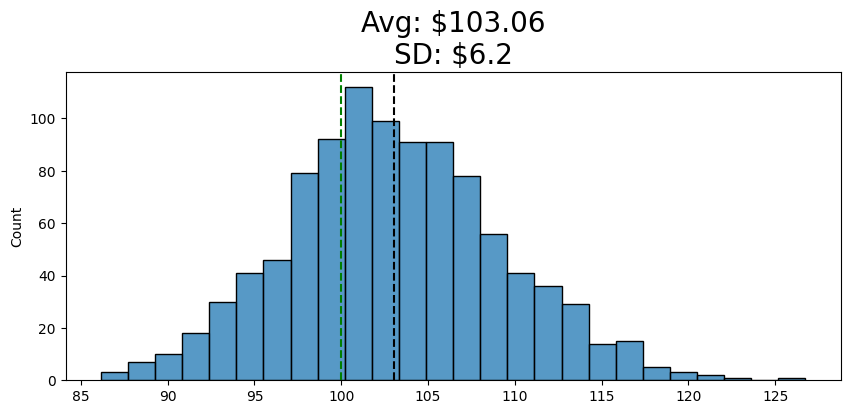

In [165]:
plt.figure(figsize=(10,4))
sns.histplot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)

# If Last Return was Positive, Buy

100%|██████████| 47/47 [00:00<00:00, 11748.75it/s]


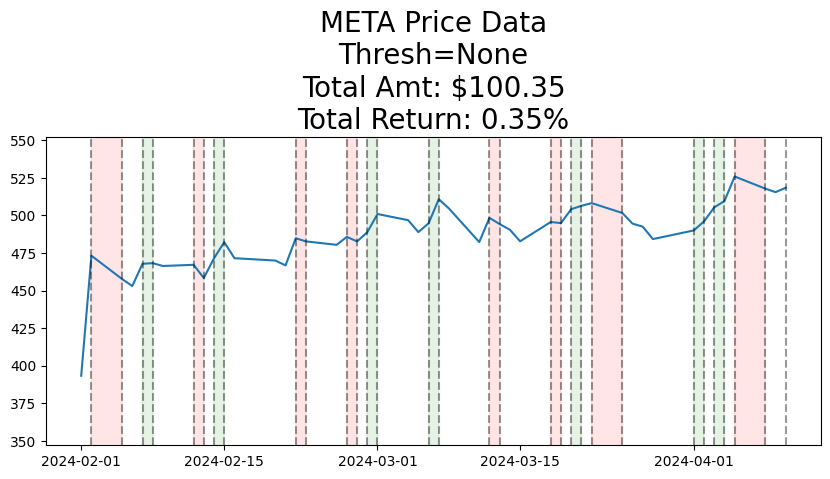

np.float64(100.34881838590474)

In [166]:
run_simulation(returns, prices, 100, 'last', None, verbose=False)

# Try AR(1) Model

100%|██████████| 47/47 [00:00<00:00, 23515.72it/s]


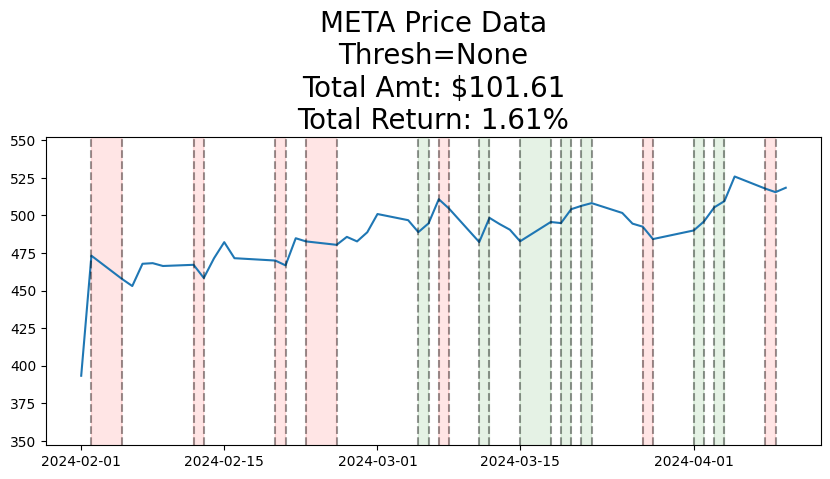

100%|██████████| 47/47 [00:00<00:00, 23213.88it/s]


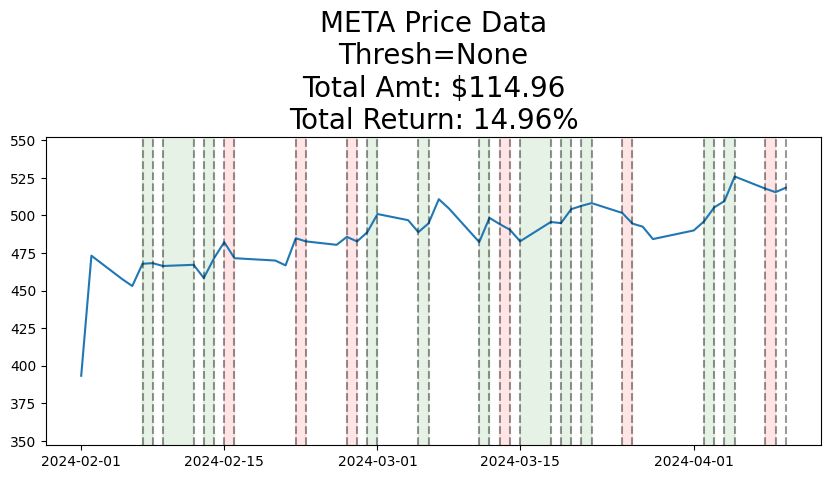

100%|██████████| 47/47 [00:00<00:00, 15669.05it/s]


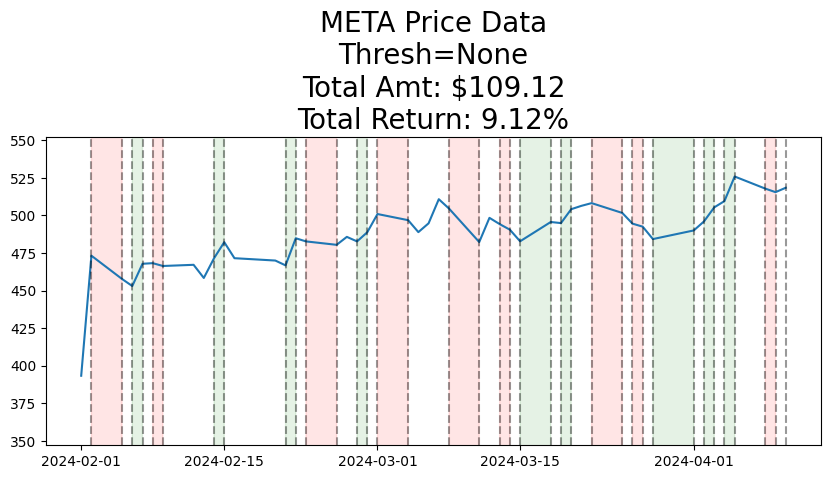

In [167]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, 0.5 , thresh, verbose=False)

# Try AR(5) Model

100%|██████████| 47/47 [00:00<00:00, 23510.11it/s]


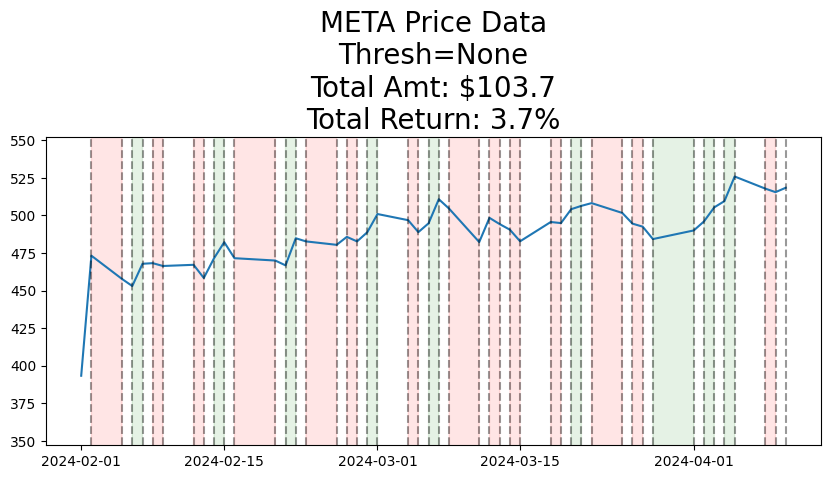

100%|██████████| 47/47 [00:00<00:00, 9393.96it/s]


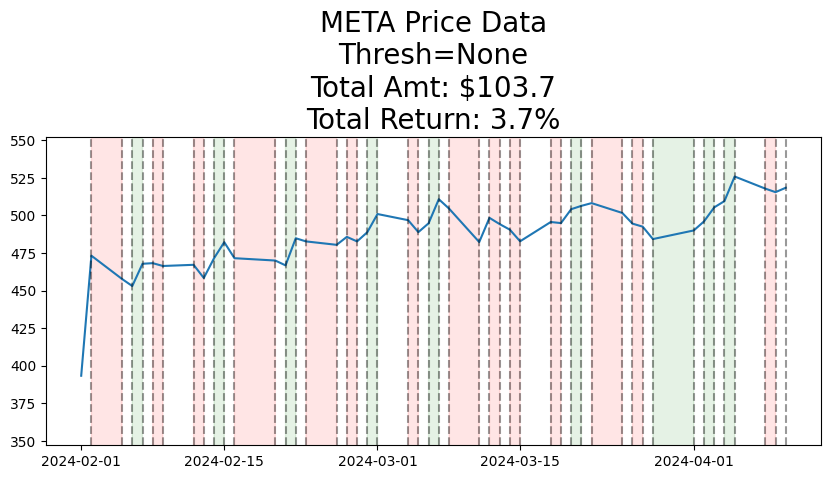

100%|██████████| 47/47 [00:00<00:00, 23900.62it/s]


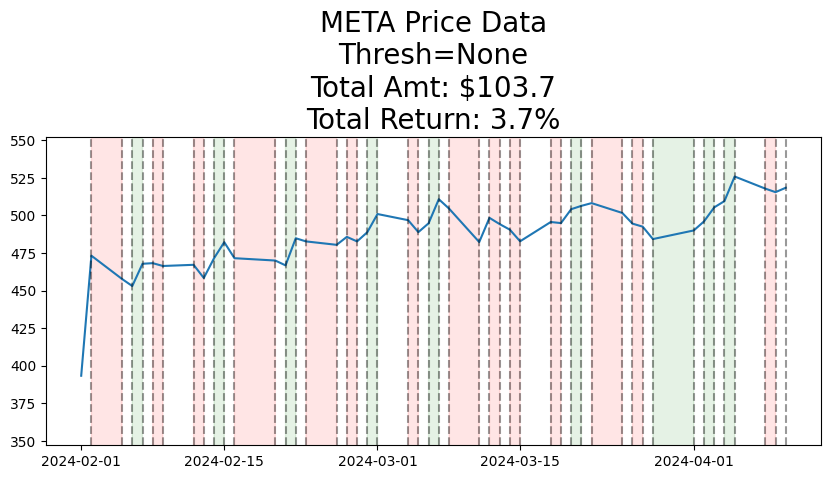

In [168]:
for thresh in [0, 0.001, 0.007]:
    run_simulation(returns, prices, 100,5.05, thresh, verbose=False)

100%|██████████| 47/47 [00:00<00:00, 15662.82it/s]


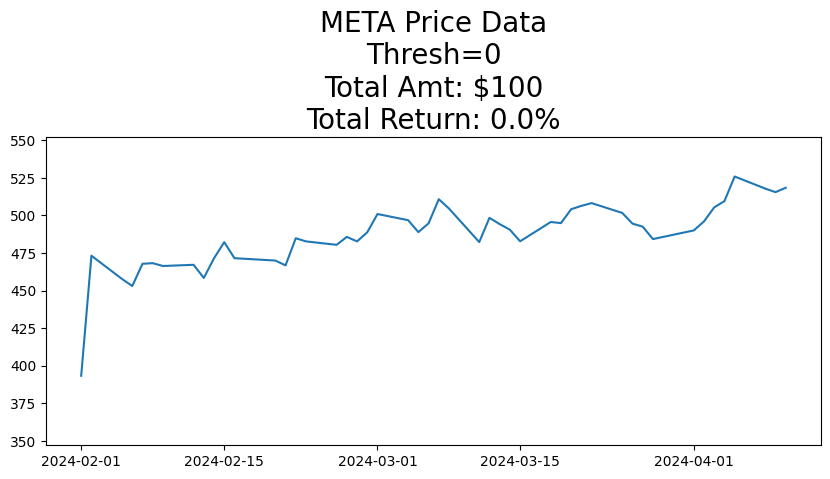

100%|██████████| 47/47 [00:00<00:00, 15665.31it/s]


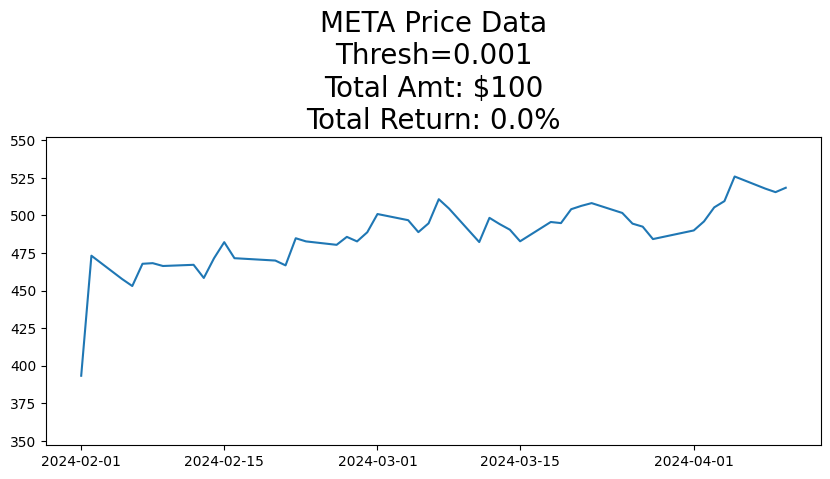

100%|██████████| 47/47 [00:00<00:00, 23099.64it/s]


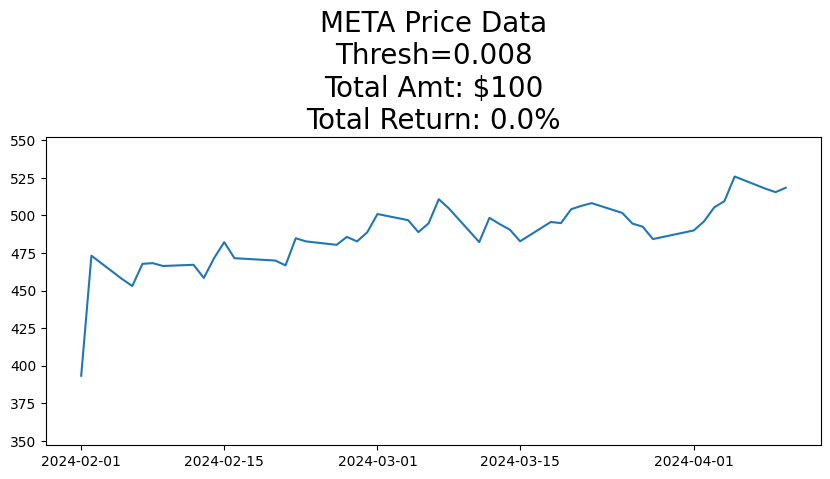

In [169]:
for thresh in [0, 0.001, 0.008]:
    run_simulation(returns, prices, 100, (5,0,0), thresh, verbose=False)

# Try ARMA(5,5) Model

100%|██████████| 47/47 [00:00<00:00, 9402.03it/s]


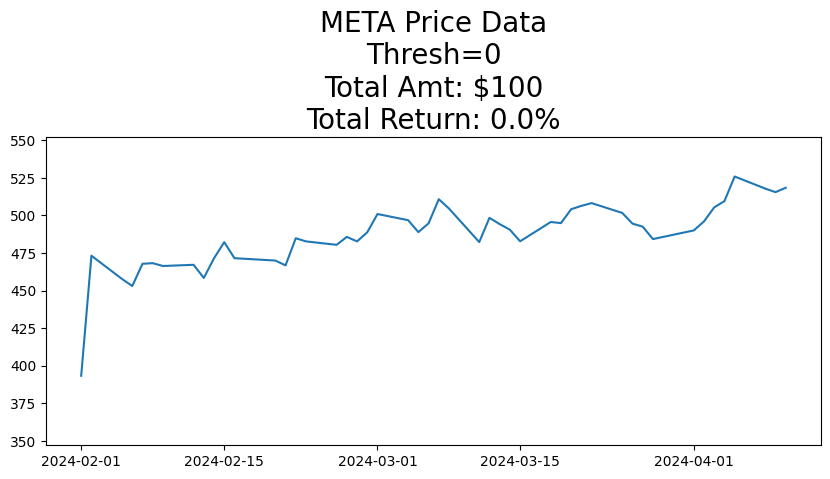

100%|██████████| 47/47 [00:00<00:00, 23274.18it/s]


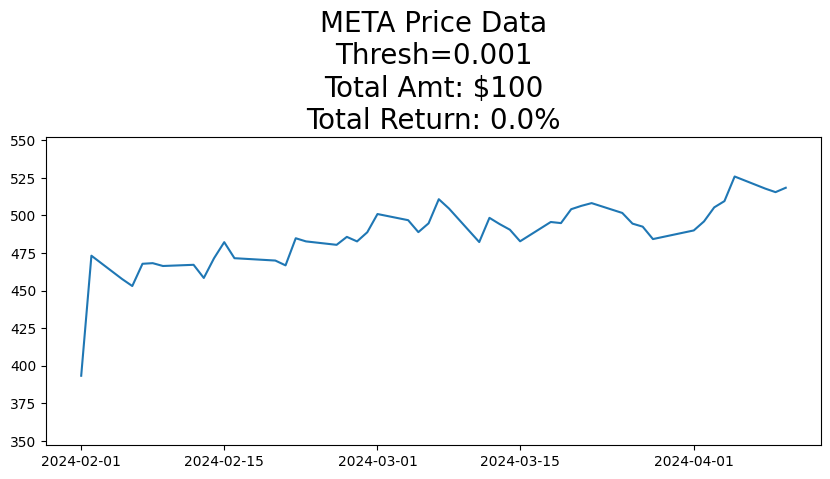

100%|██████████| 47/47 [00:00<00:00, 23538.18it/s]


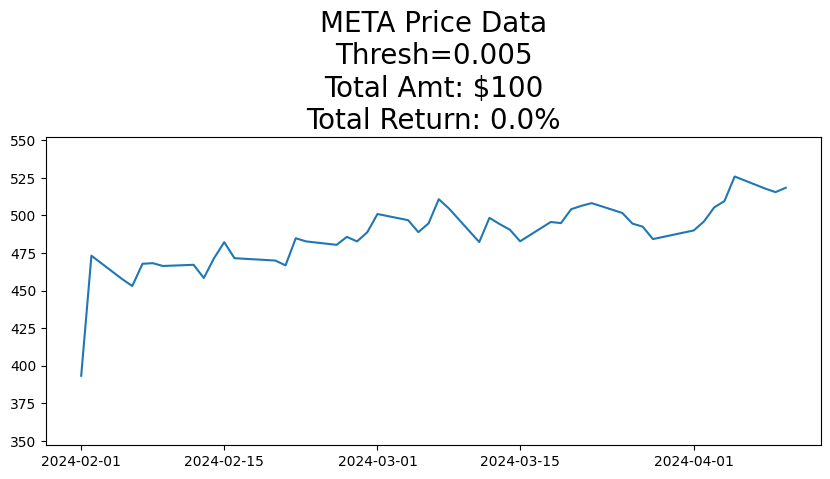

In [170]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5,0,5), thresh, verbose=False)